In [1]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import keras
from keras.applications import inception_v3
from keras import backend as K
import scipy
from keras.preprocessing import image
import numpy as np
from matplotlib import pyplot as plt

In [2]:
K.set_learning_phase(0)
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [3]:
layer_contributions = {
    'mixed2':0.2,
    'mixed3':3.,
    'mixed4':2.,
    'mixed5':1.5
}

In [4]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

loss = K.variable(0.)
for layer_name in layer_contributions:
  coeff = layer_contributions[layer_name]
  activation = layer_dict[layer_name].output
  scaling = K.prod(K.cast(K.shape(activation), 'float32'))
  print(activation.shape)
  loss = loss + coeff * K.sum(K.square(activation[:, 2:-2, 2:-2, :])) / scaling

(None, None, None, 288)
(None, None, None, 768)
(None, None, None, 768)
(None, None, None, 768)


In [5]:
dream = model.input
grads = K.gradients(loss, dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
  for i in range(iterations):
    loss_value, grad_values = eval_loss_and_grads(x)
    if max_loss is not None and loss_value > max_loss:
      break
    print('Loss:',loss_value)
    x += step * grad_values
  return x

In [9]:
def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(fname, img):
    pil_img = deprocess_image(np.copy(img))
    image.save_img(fname, pil_img)


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    print(x.shape)
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [7]:
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())
upload_files()

[]

In [14]:
step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 10
base_image_path = 'doggo.jpg'
img = preprocess_image(base_image_path)
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
  shape = tuple([int(dim/(octave_scale**i)) for dim in original_shape])
  successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
  print('Processing image shape', shape)
  print(img.shape)
  img = resize_img(img,shape)
  img = gradient_ascent(img, iterations=iterations, step=step, max_loss=max_loss)
  upscaled_shrunk_original_img  = resize_img(shrunk_original_img, shape)
  same_size_original = resize_img(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img
  img += lost_detail
  save_img('doggo_dream_'+str(shape)+'.jpg', img)
save_img('doggo_final_form.jpg', img)

Processing image shape (459, 459)
(1, 900, 900, 3)
Loss: 1.88303
Loss: 2.427524
Loss: 3.1139786
Loss: 3.8425412
Loss: 4.574446
Loss: 5.330083
Loss: 6.022688
Loss: 6.7150164
Loss: 7.391067
Loss: 8.019515
Loss: 8.632459
Loss: 9.257196
Loss: 9.827673
(1, 459, 459, 3)
Processing image shape (642, 642)
(1, 459, 459, 3)
Loss: 3.4716613
Loss: 4.795322
Loss: 5.908229
Loss: 6.855446
Loss: 7.7630715
Loss: 8.632152
Loss: 9.428158
(1, 642, 642, 3)
Processing image shape (900, 900)
(1, 642, 642, 3)
Loss: 3.4118857
Loss: 4.5780773
Loss: 5.6001534
Loss: 6.5413485
Loss: 7.4667306
Loss: 8.329961
Loss: 9.157772
Loss: 9.962869
(1, 900, 900, 3)
(1, 900, 900, 3)


(1, 900, 900, 3)


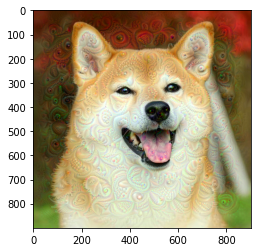

In [15]:
plt.imshow(deprocess_image(np.copy(img)))
plt.show()